In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [2]:
raw_data_file = os.path.join(os.path.pardir,'data','raw')
train_file_path = os.path.join(raw_data_file , 'train.csv')
test_file_path = os.path.join(raw_data_file , 'test.csv')

In [3]:
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

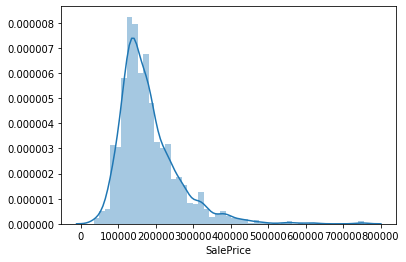

In [4]:
sns.distplot(train['SalePrice'])

According to <a href = 'https://www.statisticssolutions.com/assumptions-of-linear-regression/' > This </a>  - > A normally distributed (or close to normal) target variable helps in better modeling the relationship between target and independent variables

We see that the target variable SalePrice has a skewed distribution

In [5]:
train['SalePrice'].skew()

1.8828757597682129

Positive Skew <br>

<h1> Target Variable Dependency </h1>

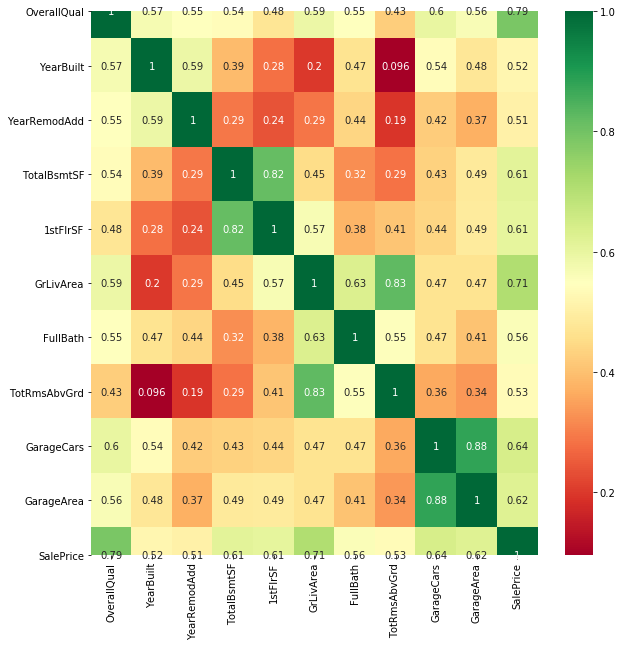

In [7]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

From this we can tell which features (OverallQual, GrLivArea and TotalBsmtSF ) are highly positively correlated with the SalePrice.

In [8]:
(train.corr()**2)["SalePrice"].sort_values(ascending = False)[1:]

OverallQual      0.625652
GrLivArea        0.502149
GarageCars       0.410124
GarageArea       0.388667
TotalBsmtSF      0.376481
1stFlrSF         0.367057
FullBath         0.314344
TotRmsAbvGrd     0.284860
YearBuilt        0.273422
YearRemodAdd     0.257151
GarageYrBlt      0.236548
MasVnrArea       0.228000
Fireplaces       0.218023
BsmtFinSF1       0.149320
LotFrontage      0.123763
WoodDeckSF       0.105244
2ndFlrSF         0.101974
OpenPorchSF      0.099765
HalfBath         0.080717
LotArea          0.069613
BsmtFullBath     0.051585
BsmtUnfSF        0.046001
BedroomAbvGr     0.028296
KitchenAbvGr     0.018471
EnclosedPorch    0.016532
ScreenPorch      0.012420
PoolArea         0.008538
MSSubClass       0.007104
OverallCond      0.006062
MoSold           0.002156
3SsnPorch        0.001988
YrSold           0.000837
LowQualFinSF     0.000656
Id               0.000480
MiscVal          0.000449
BsmtHalfBath     0.000284
BsmtFinSF2       0.000129
Name: SalePrice, dtype: float64

In [9]:
pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)

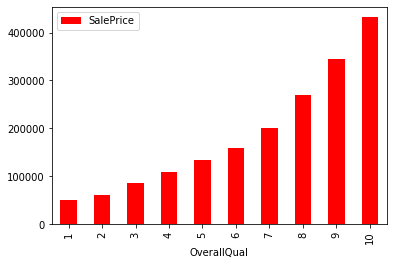

In [10]:
pivot.plot(kind='bar', color='red')

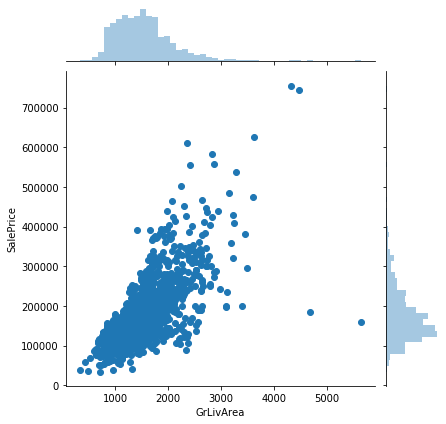

In [11]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'])


We see a direct correlation of living area with sale price <br>
Outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

In [12]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

<h1> Target Variable Transform </h1>


 mu = 180932.92 and sigma = 79467.79



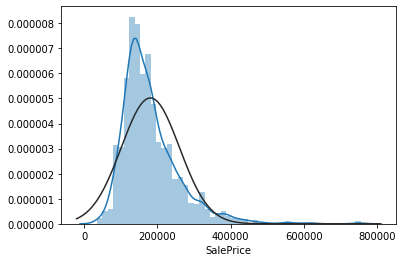

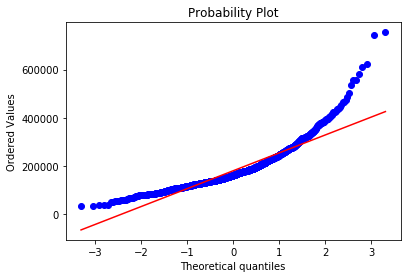

In [15]:
from scipy.stats import norm, skew 
from scipy import stats
def check_skewness(col):
    sns.distplot(train[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness('SalePrice')

<a link href = "https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55" > Here </a> i found that We'll need to log transform this variable so that it becomes normally distributed


 mu = 12.02 and sigma = 0.40



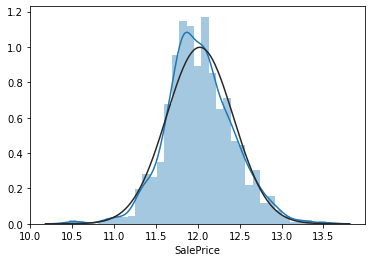

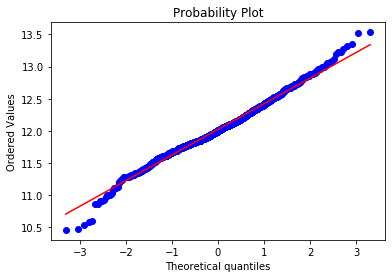

In [17]:
train["SalePrice"] = np.log1p(train["SalePrice"])

check_skewness('SalePrice')

<h1> Filling Missing Data </h1> <br>
All information for Each Variable is taken from <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data" > Here </a>

In [19]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [20]:
train.shape

(1458, 80)

In [21]:
test.shape

(1459, 79)

In [22]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

C:\Users\KISHORE\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [23]:
all_data.shape

(2917, 79)

In [25]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

Text(0.5, 1.0, 'Percent missing data by feature')

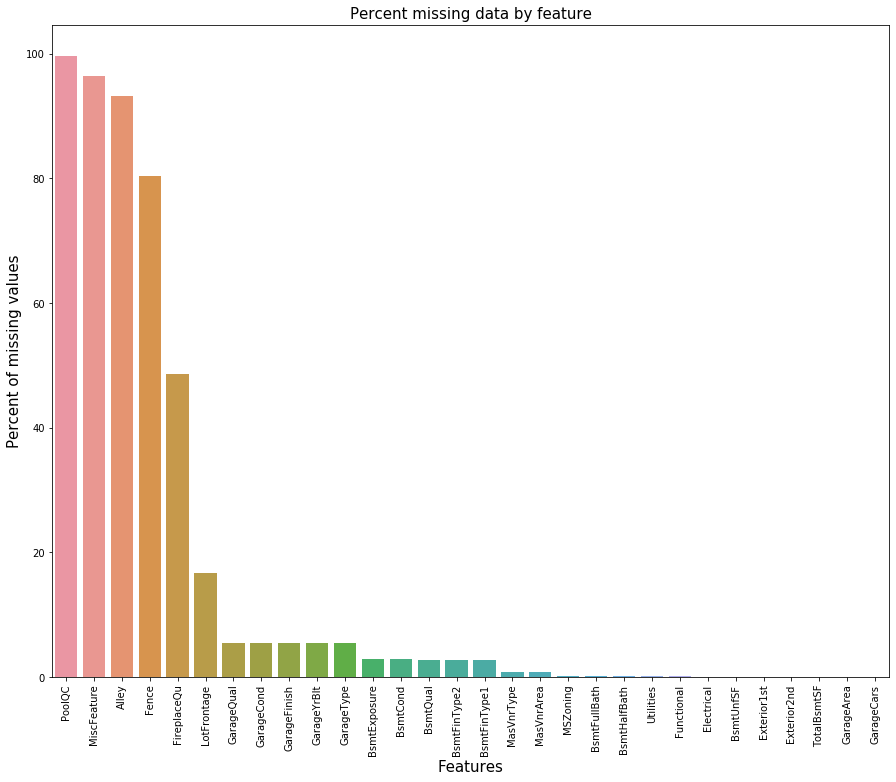

In [26]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Since , Most of the <b> PoolQC </b> features are missing , we can interpret the missing values as No Pool in the house.

In [27]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("No Pool")

Similarly, for <b> MiscFeature , Alley , Fence , FirePlaceQu </b> we derive the same meaning

In [28]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [29]:
all_data["Alley"] = all_data["Alley"].fillna("No Alley")

In [30]:
all_data["Fence"] = all_data["Fence"].fillna("No Fence")

In [31]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("No FP")

Next We Fill <b> LotFrontage </b> <br>
LotFrontage is the part of the plot that is exposed to the street. <br>
It can depend on Street , Neighborhood , Lot Area

In [33]:
grouped_df = all_data.groupby('Neighborhood')['LotFrontage']

In [34]:
for key, item in grouped_df:
    print(key,"\n")
    print(grouped_df.get_group(key).value_counts())

Blmngtn 

43.0    12
53.0     7
51.0     1
Name: LotFrontage, dtype: int64
Blueste 

24.0    7
35.0    3
Name: LotFrontage, dtype: int64
BrDale 

21.0    25
24.0     5
Name: LotFrontage, dtype: int64
BrkSide 

50.0     33
51.0     16
60.0     15
52.0     12
55.0      6
53.0      2
70.0      1
92.0      1
65.0      1
69.0      1
99.0      1
56.0      1
144.0     1
98.0      1
64.0      1
59.0      1
58.0      1
Name: LotFrontage, dtype: int64
ClearCr 

80.0     4
87.0     1
65.0     1
97.0     1
73.0     1
83.0     1
92.0     1
62.0     1
79.0     1
155.0    1
75.0     1
138.0    1
100.0    1
72.0     1
82.0     1
102.0    1
81.0     1
Name: LotFrontage, dtype: int64
CollgCr 

65.0     24
70.0     22
64.0     15
75.0     14
68.0     12
60.0     11
78.0      9
90.0      7
73.0      7
80.0      5
85.0      5
79.0      5
72.0      5
57.0      4
91.0      4
43.0      3
67.0      3
63.0      3
120.0     3
77.0      3
74.0      3
37.0      3
69.0      3
95.0      3
84.0      2
45.0      2
93.

Clearly , LotFrontage in a certain neighborhood has fairly same values. <br>
We check for LotArea now.

In [35]:
grouped_df = all_data.groupby('LotArea')['LotFrontage']

In [36]:
for key, item in grouped_df:
    print(key,"\n")
    print(grouped_df.get_group(key).value_counts())

1300 

24.0    1
Name: LotFrontage, dtype: int64
1470 

21.0    1
Name: LotFrontage, dtype: int64
1476 

21.0    1
Name: LotFrontage, dtype: int64
1477 

21.0    2
Name: LotFrontage, dtype: int64
1484 

21.0    1
Name: LotFrontage, dtype: int64
1488 

24.0    1
Name: LotFrontage, dtype: int64
1491 

21.0    1
Name: LotFrontage, dtype: int64
1495 

21.0    1
Name: LotFrontage, dtype: int64
1504 

21.0    1
Name: LotFrontage, dtype: int64
1526 

21.0    2
Name: LotFrontage, dtype: int64
1533 

21.0    3
Name: LotFrontage, dtype: int64
1596 

21.0    2
Name: LotFrontage, dtype: int64
1612 

24.0    1
Name: LotFrontage, dtype: int64
1680 

21.0    18
Name: LotFrontage, dtype: int64
1700 

Series([], Name: LotFrontage, dtype: int64)
1733 

24.0    1
Name: LotFrontage, dtype: int64
1782 

24.0    1
Name: LotFrontage, dtype: int64
1869 

21.0    1
Name: LotFrontage, dtype: int64
1879 

24.0    1
Name: LotFrontage, dtype: int64
1890 

21.0    6
Name: LotFrontage, dtype: int64
1894 

21.0    1


Certainly, lot of values to analyse , also skimming through , LotFrontage do not follow a certain pattern , and also the value_count doesn't get beyond 4 at max

In [38]:
grouped_df = all_data.groupby('Street')['LotFrontage']

In [39]:
for key, item in grouped_df:
    print(key,"\n")
    print(grouped_df.get_group(key).value_counts())

Grvl 

60.0     2
66.0     2
160.0    1
109.0    1
50.0     1
120.0    1
81.0     1
110.0    1
Name: LotFrontage, dtype: int64
Pave 

60.0     274
80.0     137
70.0     133
50.0     116
75.0     105
        ... 
137.0      1
119.0      1
195.0      1
133.0      1
126.0      1
Name: LotFrontage, Length: 128, dtype: int64


Street has only 2 types. <br>
Making it difficult to come to a conclusion with data not showing a definite pattern <br>
Neighborhood is closely related to LotFrontage and we can fill NaN value in LotFrontage as the median of LotFrontage's in each Neighborhood

In [40]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

Next , we fill variables related to Garage <br>


<b> GarageType, GarageFinish, GarageQual and GarageCond </b> <br> 
Probably , the missing value means No Garage , hence , no garage features

In [42]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

In [43]:
abc = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt', 'GarageArea', 'GarageCars']
all_data.groupby('GarageType')[abc].count()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageArea,GarageCars
GarageType,,,,,,,
2Types,23,23,23,23,23,23,23
Attchd,1722,1722,1722,1722,1722,1722,1722
Basment,36,36,36,36,36,36,36
BuiltIn,185,185,185,185,185,185,185
CarPort,15,15,15,15,15,15,15
Detchd,779,779,779,779,777,778,778
None,157,157,157,157,0,157,157


For <b> GarageYrBlt, GarageArea and GarageCars </b> NaN values mostly implies No Garage and hence , we fill 0 for Garage Area , Garage Cars and also since GarageYrBlt is undefined for this case , we fill this too with 0

In [45]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

<b> BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath </b> <br> missing values are likely zero for having no basement

In [47]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

<b> MasVnrArea and MasVnrType </b> <br>
NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type

In [49]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

<b> MSZoning </b> (I Really don't understand what this means )

In [51]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [53]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [54]:
all_data['MSZoning'].mode()[0]

'RL'

<b> Utilities  </b>

In [56]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [57]:
all_data['Utilities'].mode()[0]

'AllPub'

In [58]:
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])

<b> Functional </b>

In [60]:
all_data["Functional"].value_counts()

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

MODEing it again


In [61]:
all_data['Functional'].mode()[0]

'Typ'

In [62]:
all_data['Functional'] = all_data['Functional'].fillna(all_data['Functional'].mode()[0])

<b> MSSubClass </b>

According to the data . MSSubClass means building class.

In [64]:
all_data["MSSubClass"].value_counts()

20     1079
60      573
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

Na most likely means No building cla|ss. We will replace missing values with None

In [66]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")


<b> Exterior1st , Exterior2nd </b>

In [68]:
all_data["Exterior1st"].value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64

In [69]:
all_data["Exterior2nd"].value_counts()

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

MODEing it again 

In [71]:
all_data["Exterior1st"] = all_data["Exterior1st"].fillna(all_data["Exterior1st"].mode()[0])

In [72]:
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

<b> Electrical </b> and <b> SaleType </b>

In [74]:
all_data["Electrical"].value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [75]:
all_data["Electrical"] = all_data["Electrical"].fillna(all_data["Electrical"].mode()[0])

In [76]:
all_data["SaleType"].value_counts()

WD       2525
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

Definately MODEing again

In [78]:
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])

Is this a trick. Is it just MODEing for all categorical variables??

In [80]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
KitchenQual,0.034282


Oh, Except This , I'll trust my gut and Just MODE it

In [82]:
all_data["KitchenQual"] = all_data["KitchenQual"].fillna(all_data["KitchenQual"].mode()[0])

In [83]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


Done!

Converting Numeric Variables That are actually Categorical

In [84]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


all_data['OverallCond'] = all_data['OverallCond'].astype(str)


all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

<h1> Label Encoding </h1> <br> 
Source : <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html" > Documentation </a>

In [86]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


<h2> Treating Skewedness </h2>

Linear Regression assumes that the error terms of the model are normally distributed <br>
<a href = 'https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/' > Source </a>

In [88]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
from scipy.stats import skew

In [89]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [90]:
skewed_feats

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
LandSlope         4.973254
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
LotFrontage       1.103039
GrLivArea         1.068750
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
OverallCond       0.569314
HeatingQC         0.485534
FireplaceQu       0.332611
BedroomAbvGr      0.326568
GarageArea        0.216857
OverallQual       0.189591
FullBath          0.165514
MSSubClass        0.139709
YrSold            0.131996
BsmtFinType1      0.083641
GarageCars       -0.219297
YearRemodAdd     -0.450134
B

In [91]:
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


<b> Normalising using the Box-Cox transformation </b> <br>
<a href = 'https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55' > Source </a>

In [93]:
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

<b> Dummy Variables </b> <br>
We call the get dummies function from pandas. We also specify that the function drop the first column for each variable encoded in this way to avoid the dummy variable trap.

In [95]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 221)

In [96]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1458, 221)

<h1> Modelling </h1>

In [97]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

We do K-Fold Validation here, 
K-Folds cross-validator <br>

Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds <br> 

Each fold is then used once as a validation while the k - 1 remaining folds form the training set. <br>
<a href ='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html' > Source </a>

This is certainly advantageous over train_test_split().

In [98]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

<h3> Ridge Regression </h3>
<ul>
    <li> Ridge Regression uses L2 Regularization </li>
    <li> Regularization , in turn , avoids the overfitting the data </li>
</ul>    
<a href = 'https://www.youtube.com/watch?v=OEU22e20tWw' > Source 1 </a> <br>
<a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html' > Source 2 </a>


In [99]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1151 (0.0074)



<h3> Lasso Regression </h3> <br>
Same as Ridge Regression (almost) . takes the absolute value of theta's and not the squares of them (Ridge) <br>
<a href = 'https://www.youtube.com/watch?v=OEU22e20tWw' > Source 1 </a> <br>
<a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html' > Source 2 </a>

In [100]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1126 (0.0075)



<h3> Elastic Net Regression </h3> <br>
Elastic-Net Regression is combines Lasso Regression with Ridge Regression to give you the best of both worlds.
<a href = 'https://www.youtube.com/watch?v=1dKRdX9bfIo' > Source 1 </a> <br>
<a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html' > Source 2 </a>


In [101]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1126 (0.0076)



In [102]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1172 (0.0076)



In [103]:
LassoMd = lasso.fit(train.values,y_train)
ENetMd = ENet.fit(train.values,y_train)
KRRMd = KRR.fit(train.values,y_train)
GBoostMd = GBoost.fit(train.values,y_train)

In [104]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(ENetMd.predict(test.values)) + np.expm1(KRRMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values)) ) / 4
finalMd

array([121113.91937333, 161408.80827633, 184201.08514573, ...,
       168627.95648586, 114915.34314685, 224945.29154627])

In [105]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
sub.to_csv('submission.csv',index=False)

P.S : It Would be wrong to say , the whole work on the dataset is completely mine , I had never worked on a large(relatively) dataset before, so for the sequence of operations followed , how to deal with data and to know and use ML algorithms , i've taken help from medium blogs, youtube videos and documentation for which i have cited all the sources. But this in turn helped me get a clear idea on how and what to proceed on a dataset :) 